# Projekt 1 – perceptron Rosenblatta

## Temat: płytka sieć do nauki problemu XOR

## Tasks:
### Waiting

* Dodać opisy zdjęć - skąd są
* gradient_descent - zrobić aby było powtarzalne
* ujednolicić nazwy zmiennych
* gneracja wykresów - powtarzalność
* wykresy błędu klasyfikacji - sprawdzić czy chodziło o to a nie czy o jakieś confusion matrix
* Opis zaimplementowanych funkcji - dopieścić
    - classification_correct
* Opis zaimplementowanych zmiennych i stałych - eze

* Wykresy błędu MSE (błędu średniokwadratowego) w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym) -nie jestem pewien o co chodzi z "w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym)":
    - napisać do prowadzącego, 
    - przeszukać literature na temat mse dla MLP

* wykresy wag w obu warstwach. - okej troche mi się nie chce

### Ready
* szybsze kończenie uczenia przy spadku MSE poniżej zadanej wartości

### Done
* wykresy błędu klasyfikacji (przyjmujemy próg 0.5 dla klasyfikacji 0-1)
* Krótki opis problemu


<!-- ### To do - jak wystarczy czasu - pewnie nie wystarczy:

* dodanie momentum,
* adaptacyjny współczynnik uczenia,
* dodanie mini-batch. -->



### Opis Problemu - MLP for XOR problem
Problem XOR (Exclusive OR) stanowi kluczowy problem w uczeniu maszynowym, który ilustruje wyzwania związane z tworzeniem modeli opartych na neuronach lub sieciach neuronowych.

XOR to logiczna operacja, która zwraca prawdę (1) tylko wtedy, gdy jedno z wejść jest prawdziwe, a drugie fałszywe.

![Bramka XOR](./photos/XOR_tabela_prawdy.png)


Problem polega na tym, że XOR nie jest liniowo separowalny - oznacza to, że nie można podzielić przestrzeni wejść linią (linią prostą w dwóch wymiarach lub płaszczyzną w trzech wymiarach), aby poprawnie oddzielić przypadki prawdziwe od fałszywych.

![Przestrzeń cech XOR](./photos/XOR_przestrzen_wejsc.png)



Tradycyjne modele liniowe, takie jak regresja logistyczna czy perceptron, nie są w stanie modelować funkcji XOR, ponieważ nie mogą stworzyć odpowiedniego podziału przestrzeni wejść. Jednak sieci neuronowe z warstwą ukrytą potrafią rozwiązać ten problem poprzez tworzenie nieliniowych kombinacji wejść. Wprowadzenie warstwy ukrytej pozwala na stworzenie odpowiednich granic decyzyjnych w przestrzeni cech, umożliwiając modelowi na nauczenie się funkcji XOR.

![Rozwiązanie XOR za pomocą MLP](./photos/rozw_problemuXOR_MLP.png)



W celu sprawnego nauczenia sieci i przedstawienia skondensowanych wyników, sieć domyślnie jest uczona 4 przypadków jednocześnie, tj zbierane są gradienty dla każdego przypdadku wejścia XOR i zmiany dW1, db1, dW2, db2 są wszystkie nakładane jednocześnie.  

In [3]:
import numpy as np
#import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

In [4]:
now = datetime.now().second # trochę bardziej losowe generowanie seeda
np.random.seed(now) # on był pseudo losowy celowo XD

In [5]:
# generowanie danych na podstawie parametrów podanych przez użytkownika
def data_generator(random = False, multiply_by = 1, shuffle = True):
    if random:
        X = np.random.binomial(1, 0.5, (4*multiply_by, 2))
        Y = np.array([[X[i][0] ^ X[i][1]] for i in range(0,X.shape[0])])
    else:
        X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y = np.array([[0],[1],[1],[0]])
        X = np.tile(X, (multiply_by, 1))
        Y = np.tile(Y, (multiply_by, 1))
        
    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]
    return X, Y

def shuffleIT(X,Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X,Y

In [6]:
# funkcja aktywacji używana dla każdego neuronu
def sigmoid(x): 
	return 1.0/(1.0 + np.exp(-x))
# pochodna funkcji aktywacji używana przy obliczaniu wag w propagacji wstecznej
def sigmoid_prime(x): 
    return x * (1 - x)

In [7]:
# inicjalizacja wag i baiasów
def initialize_params():
    W1 = np.random.rand(2, 2) - 0.5
    b1 = np.random.rand(1, 2) - 0.5
    W2 = np.random.rand(2, 1) - 0.5
    b2 = np.random.rand(1, 1) - 0.5
    return W1, b1, W2, b2

In [8]:
# funkcja odpowiedzialna za przeprowadzenie obliczeń sieci opartych na wejściu (X) oraz na Wagach(W1,W2) i bajasach (b1,b2)
def forward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(X,W1) + b1
    A1 = sigmoid(Z1)
    
    Z2 = np.dot(A1,W2) + b2
    A2 = sigmoid(Z2)
    
    return A1, A2

# funkcja przeprowadzająca proces wstecznej propagacji za pomocą której obliczane są gradienty i zmiany jakie muszą być dodane do Wag i bajasów 
def backward_prop(A1, A2, W1, W2, X, Y, lr): 
    dA2 = Y - A2 # Pochodna będu MSE
    Err = ((Y - A2) ** 2) # liczenie błędu MSE 
    dZ2 = dA2 * sigmoid_prime(A2)
    
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * sigmoid_prime(A1) 

    dW1 = lr * X.T.dot(dZ1)
    db1 = lr * np.sum(dZ1,axis=0,keepdims=True) * lr 
    dW2 = lr * A1.T.dot(dZ2) 
    db2 = lr * np.sum(dZ2,axis=0,keepdims=True) * lr 

    return dW1, db1, dW2, db2, Err

def classification_correct(Y,A2):
    N = 0
    cases = 0
    for odp in zip(Y,A2):
        cases += 1
        if  odp[0][0] == 1 and odp[1][0] >= 0.5 :
            N += 1
        if  odp[0][0] == 0 and odp[1][0] <= 0.5 :
            N += 1
    return N



In [9]:
# def get_predictions(A2):
### TO DO

# def get_accuracy(predictions, Y):
### TO DO

def gradient_descent(X, Y, lr, iterations, logs = True,shuffle= False):
    W1, b1, W2, b2 = initialize_params()# funkcja zwraca wagi i bajasy używane w sieci
    #### NA LISTE CZY COS INNEGO PRZEROBIĆ
    ErrorC1 = [] # lista błędów zbieranych w trakcie uczenia
    ErrorC2 = [] # lista błędów zbieranych w trakcie uczenia
    ErrorC3 = [] # lista błędów zbieranych w trakcie uczenia
    ErrorC4 = [] # lista błędów zbieranych w trakcie uczenia
    W111 = [] 
    W112 = []
    W121 = [] 
    W122 = []
    W211 = [] 
    W212 = []
    W221 = [] 
    W222 = []
    C = [] # lista zawierająca ilość poprawnie sklasyfikowanych elementów w danej próbie 
    for i in range(iterations):
        A1, A2 = forward_prop(W1, b1, W2, b2, X)# Funkcja zwraca poziomy katywacji dla bydwu warstw
        dW1, db1, dW2, db2, Err = backward_prop( A1, A2, W1, W2, X, Y, lr)
        W1 = W1 + dW1
        b1 = b1 + db1 
        W2 = W2 + dW2 
        b2 = b2 + db2
        C.append(classification_correct(Y,A2))
        ErrorC1.append(Err[0])
        ErrorC2.append(Err[1])
        ErrorC3.append(Err[2])
        ErrorC4.append(Err[3])
        if i % 1000 == 0 and logs:
            print("Iteration: ", i)
            print(A2.T)
            print(Y.T)
        if shuffle:
            X,Y = shuffleIT(X,Y)
    print("Final Predictions")
    print(A2.T)
    print(Y.T)
    return W1, b1, W2, b2, ErrorC1,ErrorC2,ErrorC3,ErrorC4, C

In [10]:
X, Y = data_generator(random = False, multiply_by = 1, shuffle = False)
print(X)
print(Y)
W1, b1, W2, b2, ErrorC1,ErrorC2,ErrorC3,ErrorC4, C = gradient_descent(X, Y, 0.2, 30000, logs = False,shuffle= False)
_, retrun = forward_prop(W1, b1, W2, b2,[[0,0],[0,1],[1,0],[1,1]])
#print(retrun)
#print(Error)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[0]
 [1]
 [1]
 [0]]


Final Predictions
[[0.02909538 0.98197287 0.98197273 0.01998227]]
[[0 1 1 0]]


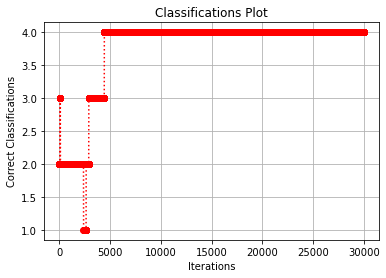

In [11]:
plt.plot(C,'o:r')
plt.xlabel('Iterations')
plt.ylabel('Correct Classifications')
plt.title('Classifications Plot')
plt.grid(True)
plt.show()

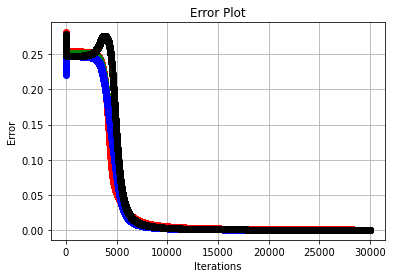

In [12]:
plt.plot(ErrorC1, 'o:r')
plt.plot(ErrorC2, 'o:g')
plt.plot(ErrorC3, 'o:b')
plt.plot(ErrorC4, 'o:k')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()


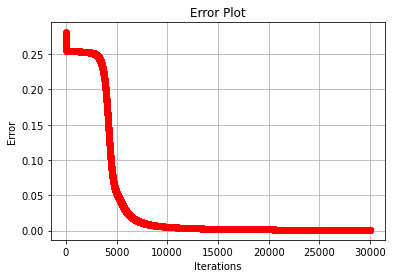

In [13]:
plt.plot(ErrorC1, 'o:r')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()

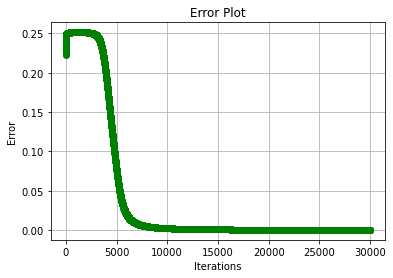

In [14]:
plt.plot(ErrorC2, 'o:g')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()

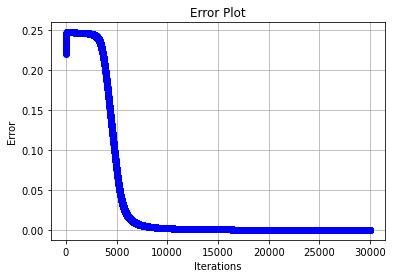

In [15]:
plt.plot(ErrorC3, 'o:b')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()

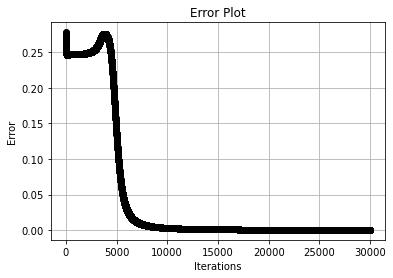

In [16]:
plt.plot(ErrorC4, 'o:k')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Plot')
plt.grid(True)
plt.show()